# Analysis of Online Rental Prices in Canada in 2024

##  Goal
This python code analyzes data of rental prices of Canadian rental properties posted online and to build a predictive model to predict prices. Below are the questions that the project answers.

* What's the monthly average rental price of posted properties?
* What are the provinces with the lowest number of postings?
* Which provinces have the lowest and highest average rental prices?
* How big is the percentage of rental properties not allowing each kind of pets?
* Is there a trend in rental prices when it comes to rental terms?
* What is the cheapest rental type and most expensive one?
* Is there a trend in rental prices when it comes the number of beds?

## Data
The data contains 25771 lines before cleanup. There are 17 rows in the dataset. This dataset contains Real Estate Rents listings in the Canada broken by Province and City. Data was collected via web scraping using python libraries.
Source for data: https://www.rentfaster.ca/
Source for description: https://www.kaggle.com/datasets/sergiygavrylov/25000-canadian-rental-housing-market-june-2024

### Variables:
* rentfaster_id:  id of property on https://www.rentfaster.com . Can be explore with www.rentfaster.ca/rentfaster_id
* city: city of property like Toronto, Calgary, Vancuver and etc.
* province: province of property like Alberta, Ontario and etc.
* address: address of property like 333 Seymour St and etc
* latitude: latitude coordinate of rental property
* longitude: longitude coordinate of rental property
* lease_term: category of rental period like Long Term, Negotiable and etc
* type: category of type a rental property like House, Apartment, Basement and etc
* price: price in CAD
* beds: count of bedrooms
* baths: count of bathrooms
* sq_feet: area of rental property in square feets
* link: right side of url for getting full details of the property rentfaster.com+link
* furnishing: Furnished or not
* availability_date: Date of availability
* smoking: allow smoke
* cats: allow cats
* dogs: allow dogs

## Findings:
On average, the rental price per month is $2152
New Brunswick, Newfoundland and Labrador, and Northwest territories have very low numbers of postings. It either means that these places don't have many rental properties or the data was collected from a source that isnèt really used in these places.

Newfoundland and Labrador seem to be the cheapest place to rent in and British Columbia seems to be the most expensive place to rent in.

35% of rental properties do not allow cats vs about 38% for dogs.

The shorter the rental term, the more expensive it is.

Parking Spot and Storage seem to be the cheapest rental types which makes sense since these rental types usually have less regulations (cost less to create) and usually have less space than a residential rental.

Acreage is the most expensive type of rentals.

There seems to be a trend in the number of beds. The more beds there are the more expensive the property is with the exception of 9 properties of 9 beds which cost 1392 monthly on average. This may be explained by outliers or an error in the data collection for 9-bed rentals.

Some outliers were found in the prices and were removed before conduting the regression models.

StandardScale was be used because we are assuming normal distributions in the data. OneHotEncoder wwas be used because the categorical variables are ordinal.

Model1 is a simple linear regression with all variables. The error metrics are too high which means that this model does not perform well in predicting rental prices. In addition, the model is performing much better in the testing then when predicting which means that there might be a case of overfitting.

Model2 was obtained by running the same parameters as model1 but without the 'city' variable. It is performing much better than model1. The independent variables can explain 47.3% of the rental prices. In addition, the model seems to perform as well in the predictions as it does in testing which means that there is no issue with overfitting. type_Vacation Home seems to be the most influential predictor of rental prices.

Model3 was obtained by running a second degree polynomial regression on all variables except for city. Similarly to model1, the error metrics are too high which means that this model also does not perform well in predicting rental prices. In addition, the model is performing much better in the testing then when predicting which means that there might be a case of overfitting.

Model4 was obtained by using the same parameters as model3 but by applying ElasticNetCV. elasticcv_model seems to be the best predictive model compared to the other three. It has the lowest MAE, MSE and RMSE values and has the highest R2 value. The model can explain 49.2% of the variations in rental prices and performs as well in predicting than in testing.

In [5450]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.linear_model import RidgeCV, ElasticNet, ElasticNetCV, LassoCV

In [5452]:
# Load data

df = pd.read_csv("canada_rent.csv")

## I. EDA and Primary Visualization

In [5455]:
#Head
df.head()

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
0,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
1,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2695.0,3 Beds,2.5,1496,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
2,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2295.0,2 Beds,2.5,1180,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
3,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2095.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,November 18,Non-Smoking,True,True
4,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True


In [5457]:
# Tail
df.tail()

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
25766,334285,Yorkton,Saskatchewan,18 Allanbrooke Dr,51.203024,-102.484782,Long Term,Apartment,920.0,Studio,1,400,/sk/yorkton/rentals/apartment/3-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
25767,334285,Yorkton,Saskatchewan,18 Allanbrooke Dr,51.203024,-102.484782,Long Term,Apartment,1450.0,3 Beds,1,810,/sk/yorkton/rentals/apartment/3-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
25768,334284,Yorkton,Saskatchewan,363 Northview Rd,51.202667,-102.485765,Long Term,Apartment,1125.0,1 Bed,1,520,/sk/yorkton/rentals/apartment/1-bedroom/pet-fr...,Unfurnished,Immediate,Non-Smoking,True,True
25769,334284,Yorkton,Saskatchewan,363 Northview Rd,51.202667,-102.485765,Long Term,Apartment,920.0,Studio,1,400,/sk/yorkton/rentals/apartment/1-bedroom/pet-fr...,Unfurnished,Immediate,Non-Smoking,True,True
25770,334284,Yorkton,Saskatchewan,363 Northview Rd,51.202667,-102.485765,Long Term,Apartment,1285.0,2 Beds,1,700,/sk/yorkton/rentals/apartment/1-bedroom/pet-fr...,Unfurnished,Immediate,Non-Smoking,True,True


In [5459]:
# Get sample
df.sample(10)

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
14973,436537,Steinbach,Manitoba,4 Brighton Lane,49.526000,-96.667920,Long Term,Apartment,1180.0,1 Bed,1,779,/mb/steinbach/rentals/apartment/1-bedroom/pet-...,Unfurnished,July 31,Smoking Allowed,True,False
4831,460855,Calgary,Alberta,720 14 Avenue SW,51.040110,-114.077981,Long Term,Apartment,1800.0,2 Beds,1,NaN,/ab/calgary/rentals/apartment/1-bedroom/beltli...,Unfurnished,No Vacancy,Non-Smoking,False,False
22881,537596,Gatineau,Quebec,78-88 Dollard-des-Ormeaux street,45.430571,-75.713592,Long Term,Apartment,1750.0,1 Bed,1,NaN,/qc/gatineau/rentals/apartment/1-bedroom/pet-f...,Unfurnished,September 01,NaN,True,True
306,497590,Calgary,Alberta,1450 20 Ave NW,51.070745,-114.093420,Long Term,Apartment,2049.0,1 Bed,1,658,/ab/calgary/rentals/apartment/1-bedroom/capito...,Unfurnished,Immediate,Non-Smoking,True,True
7246,288636,Edmonton,Alberta,10711 Saskatchewan Dr.,53.523246,-113.507003,Long Term,Apartment,1139.0,Studio,1,406,/ab/edmonton/rentals/apartment/1-bedroom/garne...,Unfurnished,Immediate,Non-Smoking,True,True
7629,425838,Edmonton,Alberta,Bonnie Doon,53.520366,-113.463845,Long Term,Basement,1450.0,1 Bed,1,800,/ab/edmonton/rentals/basement/1-bedroom/bonnie...,Unfurnished,July 01,Non-Smoking,False,False
8211,526660,Fort Saskatchewan,Alberta,NaN,53.689274,-113.254721,Long Term,Duplex,2800.0,4 Beds,3.5,1500,/ab/fort-saskatchewan/rentals/duplex/4-bedroom...,Unfurnished,July 01,Non-Smoking,True,True
13178,448114,Calgary,Alberta,30 Brentwood Common Northwest,51.087242,-114.128790,Long Term,Condo Unit,2000.0,2 Beds,1,596,/ab/calgary/rentals/condo/2-bedrooms/brentwood...,Unfurnished,July 01,Non-Smoking,True,True
617,475072,Calgary,Alberta,55 9A St. NE,51.051410,-114.040210,Long Term,Apartment,2920.0,2 Beds,2,744,/ab/calgary/rentals/apartment/1-bedroom/bridge...,Unfurnished,Immediate,Non-Smoking,True,True
23003,508615,Laval,Quebec,"3850, Boul St-Elzéar Ouest",45.568945,-73.778130,Long Term,Apartment,2180.0,2 Beds,1,1070,/qc/laval/rentals/apartment/1-bedroom/pet-frie...,Unfurnished,July 01,Non-Smoking,True,True


In [5461]:
# Stats of quantitative row(s)
df.describe()

,rentfaster_id,latitude,longitude,price
count,25771.000000,25771.000000,25771.000000,25771.000000
mean,471913.795274,48.903370,-100.332196,2151.624142
std,120330.335865,3.603257,17.917001,972.820941
min,820.000000,40.741802,-128.661880,0.000000
25%,415749.000000,45.418785,-114.074660,1600.000000
50%,522379.000000,50.913739,-113.513905,2045.000000
75%,563397.500000,51.093585,-79.401311,2550.000000
max,572635.000000,62.459246,-52.695472,29990.000000


In [5463]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rentfaster_id      25771 non-null  int64  
 1   city               25771 non-null  object 
 2   province           25771 non-null  object 
 3   address            25646 non-null  object 
 4   latitude           25771 non-null  float64
 5   longitude          25771 non-null  float64
 6   lease_term         25725 non-null  object 
 7   type               25771 non-null  object 
 8   price              25771 non-null  float64
 9   beds               25639 non-null  object 
 10  baths              25637 non-null  object 
 11  sq_feet            21659 non-null  object 
 12  link               25771 non-null  object 
 13  furnishing         25771 non-null  object 
 14  availability_date  25759 non-null  object 
 15  smoking            23069 non-null  object 
 16  cats               255

In [5465]:
# Check missing values
df.isnull().sum()

rentfaster_id           0
city                    0
province                0
address               125
latitude                0
longitude               0
lease_term             46
type                    0
price                   0
beds                  132
baths                 134
sq_feet              4112
link                    0
furnishing              0
availability_date      12
smoking              2702
cats                  173
dogs                  173
dtype: int64

In [5467]:
# Calculate the average price of rental
df.loc[:, 'price'].mean()

2151.6241422529197

On average, the rental price per month is $2152

In [5470]:
# Number of postings per province
countbyprovince=df.groupby('province')['link'].count()
print(countbyprovince)

province
Alberta                      13777
British Columbia              1154
Manitoba                       890
New Brunswick                   13
Newfoundland and Labrador       12
Northwest Territories           20
Nova Scotia                    281
Ontario                       6627
Quebec                        2269
Saskatchewan                   728
Name: link, dtype: int64


New Brunswick, Newfoundland and Labrador, and Northwest territories have very low numbers of postings. It either means that these places don't have many rental properties or the data was collected from a source that isnèt really used in these places.

In [5473]:
# Average price of postings per province
meanbyprovince=df.groupby('province')['price'].mean().reset_index(name='Mean')
meanbyprovince = meanbyprovince.sort_values(by=['Mean'], ascending=True)
print(meanbyprovince)

                    province         Mean
4  Newfoundland and Labrador  1067.083333
9               Saskatchewan  1348.745879
3              New Brunswick  1365.538462
2                   Manitoba  1674.843820
5      Northwest Territories  1877.500000
0                    Alberta  2057.428407
8                     Quebec  2097.628422
6                Nova Scotia  2162.666441
7                    Ontario  2462.598179
1           British Columbia  2492.931820


Newfoundland and Labrador seem to be the cheapest place to rent in and British Columbia seems to be the most expensive place to rent in.

In [5476]:
# Count of postings by cat or dogs allowed or not

countbycat=df.groupby('cats')['link'].count().reset_index(name='count')
countbycat = countbycat.sort_values(by=['count'], ascending=True)
print(countbycat)

countbydog=df.groupby('dogs')['link'].count().reset_index(name='count')
countbydog = countbydog.sort_values(by=['count'], ascending=True)
print(countbydog)

    cats  count
0  False   8959
1   True  16639
    dogs  count
0  False   9644
1   True  15954


35% of rental properties do not allow cats vs about 38% for dogs.

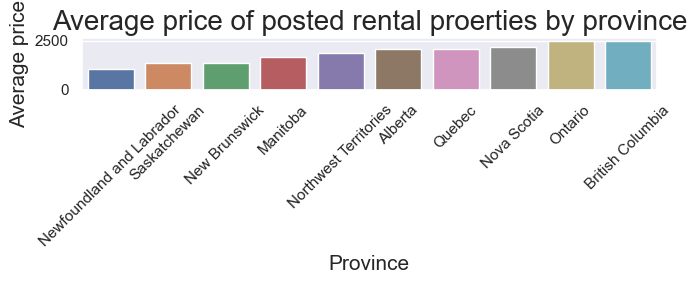

In [5479]:
# Barplot of means of prices by province
sns.barplot(data=meanbyprovince, x='province', y='Mean')
plt.title('Average price of posted rental proerties by province', size=20)
plt.xlabel('Province', size=15)
plt.xticks(rotation=45)
plt.ylabel('Average price', size=15)
plt.tight_layout()
sns.set(rc={"figure.figsize":(7,3)})

In [5481]:
# Average price of postings by lease term
meanbylease=df.groupby('lease_term')['price'].mean().reset_index(name='Mean')
meanbylease = meanbylease.sort_values(by=['Mean'], ascending=True)
print(meanbylease)

   lease_term         Mean
3  Negotiable  2057.605474
2   Long Term  2147.174353
0   12 months  2648.778947
4  Short Term  2892.760000
1    6 months  2937.500000
5      months  4500.000000


The shorter the rental term, the more expensive it is.

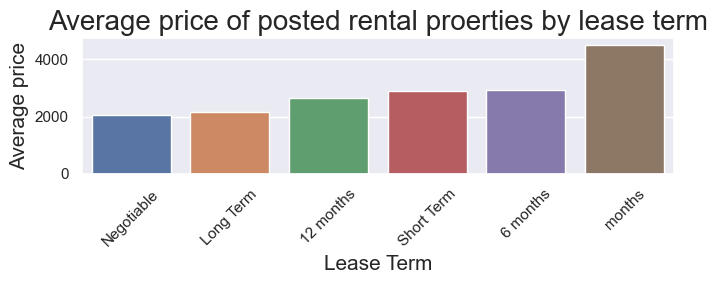

In [5484]:
# Barplot of means of prices by lease term
sns.barplot(data=meanbylease, x='lease_term', y='Mean')
plt.title('Average price of posted rental proerties by lease term', size=20)
plt.xlabel('Lease Term', size=15)
plt.xticks(rotation=45)
plt.ylabel('Average price', size=15)
plt.tight_layout()
sns.set(rc={"figure.figsize":(7,3)})

In [5486]:
# Average price of postings by rental property type
meanbytype=df.groupby('type')['price'].mean().reset_index(name='Mean')
meanbytype = meanbytype.sort_values(by=['Mean'], ascending=True)
print(meanbytype)

             type         Mean
10   Parking Spot   412.244444
12        Storage   464.418605
11  Room For Rent   919.588889
9    Office Space  1161.620690
2        Basement  1559.205546
6            Loft  1861.160000
1       Apartment  2125.436280
8          Mobile  2200.000000
7      Main Floor  2207.386420
3      Condo Unit  2263.813830
4          Duplex  2406.076459
13      Townhouse  2416.695835
5           House  3185.349098
14  Vacation Home  3750.000000
0         Acreage  3881.363636


Parking Spot and Storage seem to be the cheapest rental types which makes sense since these rental types usually have less regulations (cost less to create) and usually have less space than a residential rental.

Acreage is the most expensive type of rentals.

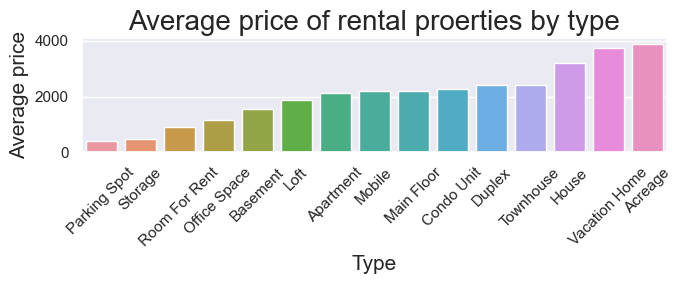

In [5489]:
# Barplot of means of prices by rental property type
sns.barplot(data=meanbytype, x='type', y='Mean')
plt.title('Average price of rental proerties by type', size=20)
plt.xlabel('Type', size=15)
plt.xticks(rotation=45)
plt.ylabel('Average price', size=15)
plt.tight_layout()
sns.set(rc={"figure.figsize":(7,3)})

In [5491]:
# Average price of postings by number of beds
meanbybeds=df.groupby('beds')['price'].mean().reset_index(name='Mean')
meanbybeds = meanbybeds.sort_values(by=['Mean'], ascending=True)
print(meanbybeds)

         beds          Mean
8      9 Beds   1391.666667
9      Studio   1404.646898
0       1 Bed   1826.208433
10  none Beds   2066.666667
1      2 Beds   2305.748085
2      3 Beds   2647.440217
5      6 Beds   2987.744681
3      4 Beds   3112.909669
6      7 Beds   3422.500000
4      5 Beds   3485.315068
7      8 Beds  19833.333333


There seems to be a trend in the number of beds. The more beds there are the more expensive the property is with the exception of 9 properties of 9 beds which cost 1392 monthly on average. This may be explained by outliers or an error in the data collection for 9-bed rentals.

In [5494]:
# Minimum 5 prices for 9 beds
df[df['beds']=='9 Beds'].nsmallest(5, 'price')

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
7122,538581,Edmonton,Alberta,10403 116 Avenue Northwest,53.566323,-113.499436,Negotiable,Room For Rent,725.0,9 Beds,4,4600,/ab/edmonton/rentals/shared/9-bedrooms/spruce-...,Furnished,Immediate,Non-Smoking,False,False
6318,423577,Edmonton,Alberta,11444 71 Ave NW,53.507819,-113.528011,Long Term,Room For Rent,750.0,9 Beds,7,NaN,/ab/edmonton/rentals/shared/9-bedrooms/belgrav...,Furnished,Immediate,Non-Smoking,False,False
7700,480078,Edmonton,Alberta,11918 68 Street Northwest,53.572613,-113.446470,Long Term,House,2700.0,9 Beds,4,NaN,/ab/edmonton/rentals/house/9-bedrooms/montrose...,Unfurnished,July 01,Non-Smoking,False,False


There seems to be only 3 lines of data for rentals with 9 beds.

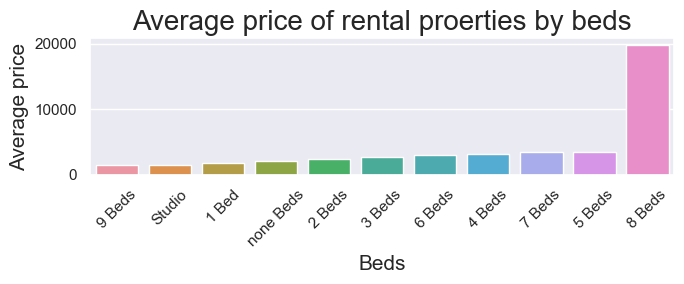

In [5497]:
# Barplot of means of prices by rental property type
sns.barplot(data=meanbybeds, x='beds', y='Mean')
plt.title('Average price of rental proerties by beds', size=20)
plt.xlabel('Beds', size=15)
plt.xticks(rotation=45)
plt.ylabel('Average price', size=15)
plt.tight_layout()
sns.set(rc={"figure.figsize":(7,3)})

## III. Data Preparation

### Data Cleanup

In [5501]:
# Remove rows with missing data

df = df.dropna(how='any',axis=0)

In [5503]:
# Check
df.isnull().sum()

rentfaster_id        0
city                 0
province             0
address              0
latitude             0
longitude            0
lease_term           0
type                 0
price                0
beds                 0
baths                0
sq_feet              0
link                 0
furnishing           0
availability_date    0
smoking              0
cats                 0
dogs                 0
dtype: int64

In [5505]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19337 entries, 0 to 25770
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rentfaster_id      19337 non-null  int64  
 1   city               19337 non-null  object 
 2   province           19337 non-null  object 
 3   address            19337 non-null  object 
 4   latitude           19337 non-null  float64
 5   longitude          19337 non-null  float64
 6   lease_term         19337 non-null  object 
 7   type               19337 non-null  object 
 8   price              19337 non-null  float64
 9   beds               19337 non-null  object 
 10  baths              19337 non-null  object 
 11  sq_feet            19337 non-null  object 
 12  link               19337 non-null  object 
 13  furnishing         19337 non-null  object 
 14  availability_date  19337 non-null  object 
 15  smoking            19337 non-null  object 
 16  cats               19337 no

In [5507]:
# Drop rows for 9 beds

df = df.drop(df[df.beds == '9 Beds'].index)

In [5509]:
# Check
len(df[df["beds"]=="9 Beds"])

0

In [5511]:
# Cheching value counts for furnishing
df['furnishing'].value_counts()

furnishing
Unfurnished                17460
Furnished                   1553
Negotiable                   318
Unfurnished, Negotiable        5
Name: count, dtype: int64

90% of rentals posted are unfurnished.

In [5514]:
# Delete rows with Unfurnished, Negotiable because we want either one and also 5 rows is too little compared to the other types.
df = df.drop(df[df.furnishing == 'Unfurnished, Negotiable'].index)

In [5516]:
# Check
len(df[df["furnishing"]=="Unfurnished, Negotiable"])

0

In [5518]:
# Cheching value counts for smoking
df['smoking'].value_counts()

smoking
Non-Smoking            18793
Smoke Free Building      327
Smoking Allowed          129
Negotiable                82
Name: count, dtype: int64

97% of postings are non-smoking rentals.

In [5521]:
# Checking value counts for beds
df['beds'].value_counts()

beds
2 Beds    7634
1 Bed     6927
3 Beds    2770
Studio    1149
4 Beds     629
5 Beds     178
6 Beds      35
7 Beds       6
8 Beds       3
Name: count, dtype: int64

The most common size of rentals is 2 bedroom properties.

In [5524]:
# Replace values by quantitative ones
df.replace(['2 Beds', '3 Beds', 'Studio', '1 Bed', '5 Beds', '4 Beds',
       '6 Beds', '8 Beds', '7 Beds', '9 Beds'], [2, 3, 0, 1, 5, 4, 6, 8, 7, 9], inplace=True)

In [5526]:
# Check
df['beds'].explode().unique()

array([2, 3, 0, 1, 5, 4, 6, 8, 7], dtype=int64)

In [5528]:
# Checking value counts for baths
df['baths'].value_counts()

baths
1       12377
2        3854
2.5      1562
1.5       767
3.5       344
3         303
4          73
4.5        22
5           9
none        9
5.5         3
0           3
7.5         2
6           1
6.5         1
7           1
Name: count, dtype: int64

16% of rentals have more than 2 bathrooms. 

In [5531]:
# Replace values by quantitative ones
df.replace(['2.5', '1', '2', '1.5', '3.5', '4', '3', '5', 'none', '4.5', '7.5',
       '5.5', '6', '6.5', '0', '7'], [2.5, 1, 2, 1.5, 3.5, 4, 3, 5, 0, 4.5, 7.5, 5.5, 6, 6.5, 0, 7], inplace=True)

In [5533]:
# Check
df['baths'].explode().unique()

array([2.5, 1. , 2. , 1.5, 3.5, 4. , 3. , 5. , 0. , 4.5, 7.5, 5.5, 6. ,
       6.5, 7. ])

In [5535]:
# Checking all possible values for availability_date
df['availability_date'].explode().unique()

array(['Immediate', 'November 18', 'July 01', 'August 01', 'June 15',
       'July 15', 'July 07', 'July 18', 'September 01', 'Negotiable',
       'No Vacancy', 'August 15', 'June 30', 'August 07', 'June 14',
       'July 04', 'July 05', 'August 06', 'July 11', 'July 31', 'June 19',
       'Call for Availability', 'September 07', 'June 17', 'October 03',
       'June 25', 'June 18', 'August 23', 'July 23', 'July 02', 'July 08',
       'June 16', 'June 20', 'June 22', 'June 23', 'June 24', 'June 26',
       'June 28', 'June 29', 'July 22', 'November 01', 'July 03',
       'July 09', 'July 06', 'July 10', 'July 12', 'July 16', 'July 17',
       'July 20', 'July 27', 'July 30', 'August 02', 'August 04',
       'August 05', 'August 09', 'August 10', 'August 11', 'August 16',
       'August 20', 'August 22', 'August 25', 'August 26', 'August 29',
       'August 30', 'August 31', 'September 02', 'September 03',
       'September 05', 'September 15', 'October 01', 'October 04',
       'Octobe

In [5537]:
# Remove all rows with no vacancy, negotiable and call for availibility
df = df.drop(df[df['availability_date'] == 'Negotiable'].index)
df = df.drop(df[df['availability_date'] == 'No Vacancy'].index)
df = df.drop(df[df['availability_date'] == 'Call for Availability'].index)

In [5539]:
# Check
df['availability_date'].explode().unique()

array(['Immediate', 'November 18', 'July 01', 'August 01', 'June 15',
       'July 15', 'July 07', 'July 18', 'September 01', 'August 15',
       'June 30', 'August 07', 'June 14', 'July 04', 'July 05',
       'August 06', 'July 11', 'July 31', 'June 19', 'September 07',
       'June 17', 'October 03', 'June 25', 'June 18', 'August 23',
       'July 23', 'July 02', 'July 08', 'June 16', 'June 20', 'June 22',
       'June 23', 'June 24', 'June 26', 'June 28', 'June 29', 'July 22',
       'November 01', 'July 03', 'July 09', 'July 06', 'July 10',
       'July 12', 'July 16', 'July 17', 'July 20', 'July 27', 'July 30',
       'August 02', 'August 04', 'August 05', 'August 09', 'August 10',
       'August 11', 'August 16', 'August 20', 'August 22', 'August 25',
       'August 26', 'August 29', 'August 30', 'August 31', 'September 02',
       'September 03', 'September 05', 'September 15', 'October 01',
       'October 04', 'October 11', 'October 16', 'October 19',
       'October 31', 'Nov

In [5541]:
# Turn the row to binary, if immediate 1 and if not immediate 0 then rename column
df['availability_date'] = df['availability_date'].apply(lambda x: 1 if x == 'Immediate' else 0)


In [5543]:
# Check
df['availability_date'].explode().unique()

array([1, 0], dtype=int64)

In [5545]:
# Rename to available now
df = df.rename(columns={'availability_date': 'available_now'})

df.head(2)

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,available_now,smoking,cats,dogs
0,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,1,Non-Smoking,True,True
1,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2695.0,3,2.5,1496,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,1,Non-Smoking,True,True


In [5547]:
# Turn sq_feet to float

df['sq_feet'] = df['sq_feet'].astype(float)

ValueError: could not convert string to float: '361 Sq. Ft.'

In [5549]:
# According to the error message, I sould delete the string part " Sq. Ft." from the row
# Remove the comma from the name column
df['sq_feet'] = df['sq_feet'].str.replace(' Sq. Ft.', '')

In [5551]:
# Turn sq_feet to float

df['sq_feet'] = df['sq_feet'].astype(float)

ValueError: could not convert string to float: '1500  above grade'

In [5553]:
# According to the error message, I sould delete the string part "  above grade." from the row
# Remove the comma from the name column
df['sq_feet'] = df['sq_feet'].str.replace('  above grade', '')

In [5555]:
# Turn sq_feet to float

df['sq_feet'] = df['sq_feet'].astype(float)

ValueError: could not convert string to float: '2193 + Walkout Basement'

In [5557]:
# According to the error message, I sould delete the string part " + Walkout Basement" from the row
# Remove the comma from the name column
df['sq_feet'] = df['sq_feet'].str.replace(' + Walkout Basement', '')

# Turn sq_feet to float

df['sq_feet'] = df['sq_feet'].astype(float)

ValueError: could not convert string to float: '1,600'

In [5559]:
# According to the error message, I sould delete the string part "," from the row
# Remove the comma from the name column
df['sq_feet'] = df['sq_feet'].str.replace(',', '')

# Turn sq_feet to float

df['sq_feet'] = df['sq_feet'].astype(float)

ValueError: could not convert string to float: 'approx. 1400'

In [5561]:
# According to the error message, I sould delete the string part "approx. " from the row
# Remove the comma from the name column
df['sq_feet'] = df['sq_feet'].str.replace('approx. ', '')

# Turn sq_feet to float

df['sq_feet'] = df['sq_feet'].astype(float)

ValueError: could not convert string to float: '490-652'

In [5563]:
# According to the error message, I sould delete the string part from the row
# Remove the comma from the name column
df['sq_feet'] = df['sq_feet'].str.replace('490-652', '571')

# Turn sq_feet to float

df['sq_feet'] = df['sq_feet'].astype(float)

ValueError: could not convert string to float: '~1000'

In [5565]:
# According to the error message, I sould delete the string part from the row
# Remove the comma from the name column
df['sq_feet'] = df['sq_feet'].str.replace('~', '')

# Turn sq_feet to float

df['sq_feet'] = df['sq_feet'].astype(float)

ValueError: could not convert string to float: '2300+1000'

In [5567]:
df['sq_feet'] = df['sq_feet'].str.replace('2300+1000', '3300')
df['sq_feet'] = df['sq_feet'].astype(float)

ValueError: could not convert string to float: '894 sq ft'

In [5569]:
df['sq_feet'] = df['sq_feet'].str.replace(' sq ft', '')
df['sq_feet'] = df['sq_feet'].astype(float)

ValueError: could not convert string to float: '1100 sqft'

In [5571]:
df['sq_feet'] = df['sq_feet'].str.replace(' sqft', '')
df['sq_feet'] = df['sq_feet'].astype(float)

ValueError: could not convert string to float: '600+'

In [5573]:
df['sq_feet'] = df['sq_feet'].str.replace('+', '')
df['sq_feet'] = df['sq_feet'].astype(float)

ValueError: could not convert string to float: 'Large'

I LOST MY PATIENCE. I tried to save as much data as I could.

In [5577]:
# Convert to float when possible
df['sq_feet'] = pd.to_numeric(df['sq_feet'], errors='coerce')
print(df)

       rentfaster_id     city      province            address   latitude  \
0             468622  Airdrie       Alberta   69 Gateway Dr NE  51.305962   
1             468622  Airdrie       Alberta   69 Gateway Dr NE  51.305962   
2             468622  Airdrie       Alberta   69 Gateway Dr NE  51.305962   
3             468622  Airdrie       Alberta   69 Gateway Dr NE  51.305962   
4             468622  Airdrie       Alberta   69 Gateway Dr NE  51.305962   
...              ...      ...           ...                ...        ...   
25766         334285  Yorkton  Saskatchewan  18 Allanbrooke Dr  51.203024   
25767         334285  Yorkton  Saskatchewan  18 Allanbrooke Dr  51.203024   
25768         334284  Yorkton  Saskatchewan   363 Northview Rd  51.202667   
25769         334284  Yorkton  Saskatchewan   363 Northview Rd  51.202667   
25770         334284  Yorkton  Saskatchewan   363 Northview Rd  51.202667   

        longitude lease_term       type   price  beds  baths  sq_feet  \
0 

In [5579]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18187 entries, 0 to 25770
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rentfaster_id  18187 non-null  int64  
 1   city           18187 non-null  object 
 2   province       18187 non-null  object 
 3   address        18187 non-null  object 
 4   latitude       18187 non-null  float64
 5   longitude      18187 non-null  float64
 6   lease_term     18187 non-null  object 
 7   type           18187 non-null  object 
 8   price          18187 non-null  float64
 9   beds           18187 non-null  int64  
 10  baths          18187 non-null  float64
 11  sq_feet        17292 non-null  float64
 12  link           18187 non-null  object 
 13  furnishing     18187 non-null  object 
 14  available_now  18187 non-null  int64  
 15  smoking        18187 non-null  object 
 16  cats           18187 non-null  bool   
 17  dogs           18187 non-null  bool   
dtypes: bool(2),

In [5581]:
# Check missing values
df.isnull().sum()

rentfaster_id      0
city               0
province           0
address            0
latitude           0
longitude          0
lease_term         0
type               0
price              0
beds               0
baths              0
sq_feet          895
link               0
furnishing         0
available_now      0
smoking            0
cats               0
dogs               0
dtype: int64

In [5583]:
# Remove rows with missing data
df = df.dropna(how='any',axis=0)

In [5585]:
# Check
df.isnull().sum()

rentfaster_id    0
city             0
province         0
address          0
latitude         0
longitude        0
lease_term       0
type             0
price            0
beds             0
baths            0
sq_feet          0
link             0
furnishing       0
available_now    0
smoking          0
cats             0
dogs             0
dtype: int64

Axes(0.125,0.11;0.775x0.77)


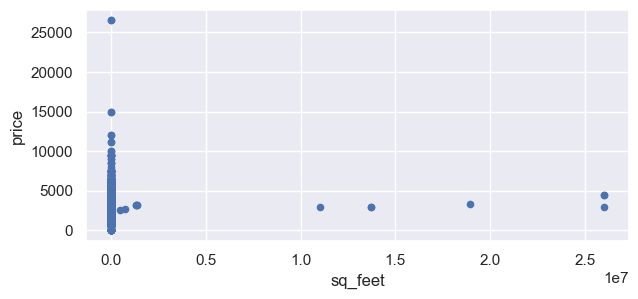

In [5587]:
# Scatterplot of price by sq_feet

scatterbyfeet=df.plot.scatter(x = 'sq_feet', y = 'price')
print(scatterbyfeet)

In [5589]:
#Let's remove the top 5 sq feet cause they don't make sense

In [5591]:
# Check minimum and maximum square feet

maxvalue = df['sq_feet'].max()
print(maxvalue)

# Yeah it definity doesn't make sense

26001200.0


In [5593]:
df = df.drop(df[df['sq_feet'] == 26001200.0].index)

In [5595]:
maxvalue = df['sq_feet'].max()
print(maxvalue)

18911100.0


In [5597]:
df = df.drop(df[df['sq_feet'] == 18911100.0].index)

In [5599]:
maxvalue = df['sq_feet'].max()
print(maxvalue)

13711141.0


In [5601]:
df = df.drop(df[df['sq_feet'] == 13711141.0].index)

In [5603]:
maxvalue = df['sq_feet'].max()
print(maxvalue)

11001100.0


In [5605]:
df = df.drop(df[df['sq_feet'] == 11001100.0].index)

In [5607]:
maxvalue = df['sq_feet'].max()
print(maxvalue)

1350800.0


Axes(0.125,0.11;0.775x0.77)


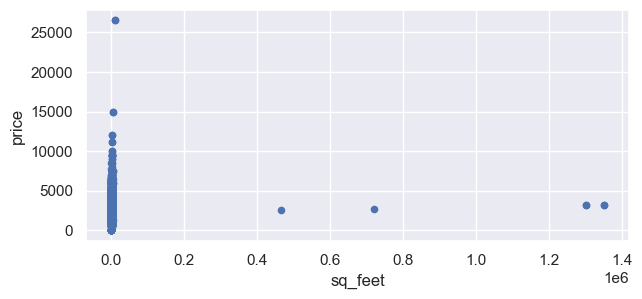

In [5609]:
# Scatterplot of price by sq_feet

scatterbyfeet=df.plot.scatter(x = 'sq_feet', y = 'price')
print(scatterbyfeet)

In [5611]:
# More cleanup

df = df.drop(df[df['sq_feet'] == 1350800.0].index)

maxvalue = df['sq_feet'].max()
print(maxvalue)

1300400.0


In [5613]:
df = df.drop(df[df['sq_feet'] == 1300400.0].index)

maxvalue = df['sq_feet'].max()
print(maxvalue)

720240.0


In [5615]:
df = df.drop(df[df['sq_feet'] == 720240.0].index)

maxvalue = df['sq_feet'].max()
print(maxvalue)

465200.0


In [5617]:
df = df.drop(df[df['sq_feet'] == 465200.0].index)

maxvalue = df['sq_feet'].max()
print(maxvalue)

11700.0


In [5619]:
# Also remove the outlier in price
maxvalue = df['price'].max()
print(maxvalue)

26500.0


In [5621]:
df = df.drop(df[df['price'] == 26500.0].index)

Axes(0.125,0.11;0.775x0.77)


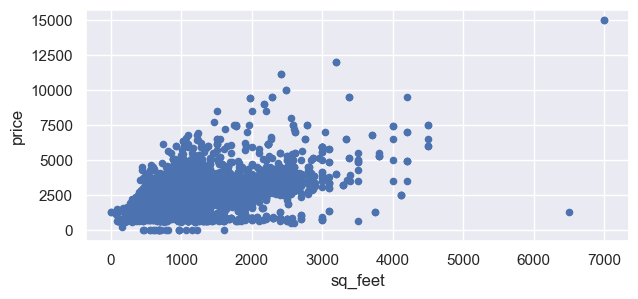

In [5623]:
# Scatterplot of price by sq_feet

scatterbyfeet=df.plot.scatter(x = 'sq_feet', y = 'price')
print(scatterbyfeet)

In [5625]:
# Looks so much better now

In [5627]:
# Remove useless columns
df=df.drop(['rentfaster_id', 'address', 'link'], axis=1)

### Dummy Variables

OneHotEncoder will be used because the categorical variables are ordinal.

In [5630]:
# Create instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output = False)

encoded_cols = encoder.fit_transform(df[['city', 'province', 'lease_term', 'type', 'furnishing', 'smoking', 'cats', 'dogs']])

# get_feature_names_out() returns the transformed feature names
new_df = pd.DataFrame(encoded_cols, columns = encoder.get_feature_names_out(['city', 'province', 'lease_term', 'type', 'furnishing', 'smoking', 'cats', 'dogs']))

new_df.head()



,city_Airdrie,city_Ajax,city_Aldersyde,city_Amherstview,city_Ancaster,city_Assiniboia,city_Aurora,city_Ayr,city_Balzac,city_Barrie,...,type_Room For Rent,type_Townhouse,type_Vacation Home,furnishing_Negotiable,furnishing_Unfurnished,smoking_Non-Smoking,smoking_Smoke Free Building,smoking_Smoking Allowed,cats_True,dogs_True
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0


In [5632]:
# Join dataframes

dfm1 = df.drop(columns=['city', 'province', 'lease_term', 'type', 'furnishing', 'smoking', 'cats', 'dogs']).join(new_df)
dfm1

,latitude,longitude,price,beds,baths,sq_feet,available_now,city_Airdrie,city_Ajax,city_Aldersyde,...,type_Room For Rent,type_Townhouse,type_Vacation Home,furnishing_Negotiable,furnishing_Unfurnished,smoking_Non-Smoking,smoking_Smoke Free Building,smoking_Smoking Allowed,cats_True,dogs_True
0,51.305962,-114.012515,2495.0,2,2.5,1403.0,1,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
1,51.305962,-114.012515,2695.0,3,2.5,1496.0,1,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
2,51.305962,-114.012515,2295.0,2,2.5,1180.0,1,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,51.305962,-114.012515,2095.0,2,2.5,1403.0,0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,51.305962,-114.012515,2495.0,2,2.5,1403.0,1,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25766,51.203024,-102.484782,920.0,0,1.0,400.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25767,51.203024,-102.484782,1450.0,3,1.0,810.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25768,51.202667,-102.485765,1125.0,1,1.0,520.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25769,51.202667,-102.485765,920.0,0,1.0,400.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5634]:
dfm1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17277 entries, 0 to 25770
Columns: 253 entries, latitude to dogs_True
dtypes: float64(251), int64(2)
memory usage: 34.0 MB


In [5636]:
# Remove rows with missing data
dfm1 = dfm1.dropna(how='any',axis=0)

## Regression Models

### Model 1: Linear regression with all variables

In [5640]:
# Separate features and target variable

X = dfm1.drop("price", axis=1)
y = dfm1['price']

In [5642]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

StandardScale will be used because we are assuming normal distributions in the data because we will be running regressions.

In [5644]:
# Initialize the scaler
scaler1 = StandardScaler()

# Fit scaler on training data and transform both training and test data
X_train = scaler1.fit_transform(X_train)
X_test= scaler1.transform(X_test)

In [5646]:
# Create instance of model
model1 = LinearRegression()

# Train model
model1.fit(X_train, y_train)

LinearRegression()

In [5648]:
# Obtain y hat values
y_pred = model1.predict(X_test)

# Obtain metrics
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
coef_of_detr = r2_score(y_test, y_pred)

MAE, MSE, RMSE, coef_of_detr

(35826740346812.12,
 3.910277307070212e+29,
 625322101566081.9,
 -5.499678617478677e+23)

In [5650]:
# Predictions for both train and test data
train_pred = model1.predict(X_train)
test_pred = model1.predict(X_test)
    

# Calculate RMSE for training set
train_RMSE = np.sqrt(mean_squared_error(y_train, train_pred))

# Calculate RMSE for testing set
test_RMSE = np.sqrt(mean_squared_error(y_test, test_pred))

train_RMSE, test_RMSE

(611.6996642869874, 625322101566081.9)

The error metrics are too high which means that this model does not perform well in predicting rental prices. In addition, the model is performing much better in the testing then when predicting which means that there might be a case of overfitting.

### Model 2: Modified linear regression

In [5754]:
# Try a model with decreased number of variables by removing the city variable 

In [5756]:
# Remove city
dfm2=df.drop(['city'], axis=1)

In [5758]:
# Create instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output = False)
encoded_cols2 = encoder.fit_transform(dfm2[['province', 'lease_term', 'type', 'furnishing', 'smoking', 'cats', 'dogs']])

# get_feature_names_out() returns the transformed feature names
new_df2 = pd.DataFrame(encoded_cols2, columns = encoder.get_feature_names_out(['province', 'lease_term', 'type', 'furnishing', 'smoking', 'cats', 'dogs']))

new_df2.head()

,province_British Columbia,province_Manitoba,province_New Brunswick,province_Newfoundland and Labrador,province_Nova Scotia,province_Ontario,province_Quebec,province_Saskatchewan,lease_term_6 months,lease_term_Long Term,...,type_Room For Rent,type_Townhouse,type_Vacation Home,furnishing_Negotiable,furnishing_Unfurnished,smoking_Non-Smoking,smoking_Smoke Free Building,smoking_Smoking Allowed,cats_True,dogs_True
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0


In [5760]:
# Join dataframes
dfm2 = dfm2.drop(columns=['province', 'lease_term', 'type', 'furnishing', 'smoking', 'cats', 'dogs']).join(new_df2)
dfm2

,latitude,longitude,price,beds,baths,sq_feet,available_now,province_British Columbia,province_Manitoba,province_New Brunswick,...,type_Room For Rent,type_Townhouse,type_Vacation Home,furnishing_Negotiable,furnishing_Unfurnished,smoking_Non-Smoking,smoking_Smoke Free Building,smoking_Smoking Allowed,cats_True,dogs_True
0,51.305962,-114.012515,2495.0,2,2.5,1403.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
1,51.305962,-114.012515,2695.0,3,2.5,1496.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
2,51.305962,-114.012515,2295.0,2,2.5,1180.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,51.305962,-114.012515,2095.0,2,2.5,1403.0,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,51.305962,-114.012515,2495.0,2,2.5,1403.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25766,51.203024,-102.484782,920.0,0,1.0,400.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25767,51.203024,-102.484782,1450.0,3,1.0,810.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25768,51.202667,-102.485765,1125.0,1,1.0,520.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25769,51.202667,-102.485765,920.0,0,1.0,400.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5762]:
dfm2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17277 entries, 0 to 25770
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   latitude                            17277 non-null  float64
 1   longitude                           17277 non-null  float64
 2   price                               17277 non-null  float64
 3   beds                                17277 non-null  int64  
 4   baths                               17277 non-null  float64
 5   sq_feet                             17277 non-null  float64
 6   available_now                       17277 non-null  int64  
 7   province_British Columbia           11935 non-null  float64
 8   province_Manitoba                   11935 non-null  float64
 9   province_New Brunswick              11935 non-null  float64
 10  province_Newfoundland and Labrador  11935 non-null  float64
 11  province_Nova Scotia                11935 non-

In [5764]:
# Remove rows with missing data
dfm2 = dfm2.dropna(how='any',axis=0)

In [5766]:
dfm2.head(5)

,latitude,longitude,price,beds,baths,sq_feet,available_now,province_British Columbia,province_Manitoba,province_New Brunswick,...,type_Room For Rent,type_Townhouse,type_Vacation Home,furnishing_Negotiable,furnishing_Unfurnished,smoking_Non-Smoking,smoking_Smoke Free Building,smoking_Smoking Allowed,cats_True,dogs_True
0,51.305962,-114.012515,2495.0,2,2.5,1403.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
1,51.305962,-114.012515,2695.0,3,2.5,1496.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
2,51.305962,-114.012515,2295.0,2,2.5,1180.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,51.305962,-114.012515,2095.0,2,2.5,1403.0,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,51.305962,-114.012515,2495.0,2,2.5,1403.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0


In [5768]:
# Separate features and target variable
X = dfm2.drop("price", axis=1)
y = dfm2['price']

In [5770]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [5772]:
# Initialize the scaler
scaler2 = StandardScaler()

# Fit scaler on training data and transform both training and test data
X_train= scaler2.fit_transform(X_train)
X_test= scaler2.transform(X_test)

In [5774]:
# Create instance of model
model2 = LinearRegression()

# Train model
model2.fit(X_train, y_train)

LinearRegression()

In [5776]:
# Obtain y hat values
y_pred = model2.predict(X_test)

# Obtain metrics
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
coef_of_detr = r2_score(y_test, y_pred)

MAE, MSE, RMSE, coef_of_detr

(375.8617457061917, 374534.6709329355, 611.9923781657216, 0.4732290936221082)

In [5778]:
# Predictions for both train and test data
train_pred = model2.predict(X_train)
test_pred = model2.predict(X_test)
    

# Calculate RMSE for training set
train_RMSE = np.sqrt(mean_squared_error(y_train, train_pred))

# Calculate RMSE for testing set
test_RMSE = np.sqrt(mean_squared_error(y_test, test_pred))

train_RMSE, test_RMSE

(627.2576257431308, 611.9923781657216)

Model2 is performing much better than model1. The independent variables can explain 47.3% of the rental prices. In addition, the model seems to perform as well in the predictions as it does in testing which means that there is no issue with overfitting.

In [5781]:
model2 = LinearRegression()

model2.fit(X,y)

LinearRegression()

In [5783]:
# Check coefficients
coeff_dfm2 = pd.DataFrame(model2.coef_,X.columns,columns=['Coefficient'])
coeff_dfm2

,Coefficient
latitude,-164.931840
longitude,-19.275135
beds,10.659472
baths,385.197408
sq_feet,0.576461
available_now,-17.543177
province_British Columbia,15.503334
province_Manitoba,-138.843650
province_New Brunswick,-338.192263
province_Newfoundland and Labrador,-197.482721


In [5785]:
model2.intercept_

7321.614859111369

type_Vacation Home seems to be the most influential predictor of rental prices.

### Model 3: Polynomial regression

In [5818]:
# Remove only city
dfm3=df.drop(['city'], axis=1)

In [5820]:
# Create instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output = False)

encoded_cols3 = encoder.fit_transform(dfm3[['province', 'lease_term', 'type', 'furnishing', 'smoking', 'cats', 'dogs']])

# get_feature_names_out() returns the transformed feature names
new_df3 = pd.DataFrame(encoded_cols3, columns = encoder.get_feature_names_out(['province', 'lease_term', 'type', 'furnishing', 'smoking', 'cats', 'dogs']))

new_df3.head()

,province_British Columbia,province_Manitoba,province_New Brunswick,province_Newfoundland and Labrador,province_Nova Scotia,province_Ontario,province_Quebec,province_Saskatchewan,lease_term_6 months,lease_term_Long Term,...,type_Room For Rent,type_Townhouse,type_Vacation Home,furnishing_Negotiable,furnishing_Unfurnished,smoking_Non-Smoking,smoking_Smoke Free Building,smoking_Smoking Allowed,cats_True,dogs_True
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0


In [5822]:
# Join dataframes

dfm3 = dfm3.drop(columns=['province', 'lease_term', 'type', 'furnishing', 'smoking', 'cats', 'dogs']).join(new_df3)
dfm3

,latitude,longitude,price,beds,baths,sq_feet,available_now,province_British Columbia,province_Manitoba,province_New Brunswick,...,type_Room For Rent,type_Townhouse,type_Vacation Home,furnishing_Negotiable,furnishing_Unfurnished,smoking_Non-Smoking,smoking_Smoke Free Building,smoking_Smoking Allowed,cats_True,dogs_True
0,51.305962,-114.012515,2495.0,2,2.5,1403.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
1,51.305962,-114.012515,2695.0,3,2.5,1496.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
2,51.305962,-114.012515,2295.0,2,2.5,1180.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,51.305962,-114.012515,2095.0,2,2.5,1403.0,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,51.305962,-114.012515,2495.0,2,2.5,1403.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25766,51.203024,-102.484782,920.0,0,1.0,400.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25767,51.203024,-102.484782,1450.0,3,1.0,810.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25768,51.202667,-102.485765,1125.0,1,1.0,520.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25769,51.202667,-102.485765,920.0,0,1.0,400.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5824]:
# Info
dfm3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17277 entries, 0 to 25770
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   latitude                            17277 non-null  float64
 1   longitude                           17277 non-null  float64
 2   price                               17277 non-null  float64
 3   beds                                17277 non-null  int64  
 4   baths                               17277 non-null  float64
 5   sq_feet                             17277 non-null  float64
 6   available_now                       17277 non-null  int64  
 7   province_British Columbia           11935 non-null  float64
 8   province_Manitoba                   11935 non-null  float64
 9   province_New Brunswick              11935 non-null  float64
 10  province_Newfoundland and Labrador  11935 non-null  float64
 11  province_Nova Scotia                11935 non-

In [5826]:
# Remove rows with missing data
dfm3 = dfm3.dropna(how='any',axis=0)

In [5828]:
# Separate features and target variable

X = dfm3.drop("price", axis=1)
y = dfm3['price']

In [5830]:
# Create an instance of PolynomialFeatures
poly_converter = PolynomialFeatures(degree=2, include_bias=False)

# Fit converter to X features + transform features
poly_features = poly_converter.fit_transform(X)

In [5832]:
# Compare shape of X vs. shape of new features

X.shape, poly_features.shape

((11935, 37), (11935, 740))

In [5834]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.15, random_state=1)

In [5836]:
# Scale data
scaler3 = StandardScaler()

# Fit-transform training data
X_train = scaler3.fit_transform(X_train)

# Transform only on test data
X_test = scaler3.transform(X_test)

In [5840]:
# Create instance of model
model3 = LinearRegression()

# Train regression model on 740 features instead of 30
model3.fit(X_train, y_train)

LinearRegression()

In [5842]:
y_pred = model3.predict(X_test)

# Obtain metrics
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
coef_of_detrm = r2_score(y_test, y_pred)

MAE, MSE, RMSE, coef_of_detrm

(333636806887.2757,
 9.466368152388267e+25,
 9729526274381.639,
 -1.3314140769182042e+20)

In [5844]:
# Predictions for both train and test data
train_pred = model3.predict(X_train)
test_pred = model3.predict(X_test)
    

# Calculate RMSE for training set
train_RMSE = np.sqrt(mean_squared_error(y_train, train_pred))

# Calculate RMSE for testing set
test_RMSE = np.sqrt(mean_squared_error(y_test, test_pred))

train_RMSE, test_RMSE

(570.4512661212814, 9729526274381.639)

Similarly to model1, the error metrics are too high which means that this model also does not perform well in predicting rental prices. In addition, the model is performing much better in the testing then when predicting which means that there might be a case of overfitting.

In [5848]:
model3 = LinearRegression()
model3.fit(X,y)

# Check coefficients
coeff_dfm3 = pd.DataFrame(model3.coef_,X.columns,columns=['Coefficient'])
coeff_dfm3

,Coefficient
latitude,-164.931840
longitude,-19.275135
beds,10.659472
baths,385.197408
sq_feet,0.576461
available_now,-17.543177
province_British Columbia,15.503334
province_Manitoba,-138.843650
province_New Brunswick,-338.192263
province_Newfoundland and Labrador,-197.482721


In [5850]:
#Intercept
model3.intercept_

7321.614859111369

### Model 4: ElasticNetCV

In [5864]:
# Remove city cause there's way too many variables
dfm4=df.drop(['city'], axis=1)

In [5866]:
# Create instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output = False)

encoded_cols4 = encoder.fit_transform(dfm4[['province', 'lease_term', 'type', 'furnishing', 'smoking', 'cats', 'dogs']])

# get_feature_names_out() returns the transformed feature names
new_df4 = pd.DataFrame(encoded_cols4, columns = encoder.get_feature_names_out(['province', 'lease_term', 'type', 'furnishing', 'smoking', 'cats', 'dogs']))

new_df4.head()

,province_British Columbia,province_Manitoba,province_New Brunswick,province_Newfoundland and Labrador,province_Nova Scotia,province_Ontario,province_Quebec,province_Saskatchewan,lease_term_6 months,lease_term_Long Term,...,type_Room For Rent,type_Townhouse,type_Vacation Home,furnishing_Negotiable,furnishing_Unfurnished,smoking_Non-Smoking,smoking_Smoke Free Building,smoking_Smoking Allowed,cats_True,dogs_True
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0


In [5868]:
# Join dataframes

dfm4 = dfm4.drop(columns=['province', 'lease_term', 'type', 'furnishing', 'smoking', 'cats', 'dogs']).join(new_df4)
dfm4

,latitude,longitude,price,beds,baths,sq_feet,available_now,province_British Columbia,province_Manitoba,province_New Brunswick,...,type_Room For Rent,type_Townhouse,type_Vacation Home,furnishing_Negotiable,furnishing_Unfurnished,smoking_Non-Smoking,smoking_Smoke Free Building,smoking_Smoking Allowed,cats_True,dogs_True
0,51.305962,-114.012515,2495.0,2,2.5,1403.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
1,51.305962,-114.012515,2695.0,3,2.5,1496.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
2,51.305962,-114.012515,2295.0,2,2.5,1180.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,51.305962,-114.012515,2095.0,2,2.5,1403.0,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,51.305962,-114.012515,2495.0,2,2.5,1403.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25766,51.203024,-102.484782,920.0,0,1.0,400.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25767,51.203024,-102.484782,1450.0,3,1.0,810.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25768,51.202667,-102.485765,1125.0,1,1.0,520.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25769,51.202667,-102.485765,920.0,0,1.0,400.0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5870]:
# Info
dfm4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17277 entries, 0 to 25770
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   latitude                            17277 non-null  float64
 1   longitude                           17277 non-null  float64
 2   price                               17277 non-null  float64
 3   beds                                17277 non-null  int64  
 4   baths                               17277 non-null  float64
 5   sq_feet                             17277 non-null  float64
 6   available_now                       17277 non-null  int64  
 7   province_British Columbia           11935 non-null  float64
 8   province_Manitoba                   11935 non-null  float64
 9   province_New Brunswick              11935 non-null  float64
 10  province_Newfoundland and Labrador  11935 non-null  float64
 11  province_Nova Scotia                11935 non-

In [5872]:
# Remove rows with missing data
dfm4 = dfm4.dropna(how='any',axis=0)

In [5874]:
# Separate features and target variable
X = dfm4.drop("price", axis=1)
y = dfm4['price']

In [5876]:
# Create an instance of PolynomialFeatures
poly_converter = PolynomialFeatures(degree=2, include_bias=False)

# Fit converter to X features + transform features
poly_features = poly_converter.fit_transform(X)

In [5878]:
# Compare shape of X vs. shape of new features
X.shape, poly_features.shape

((11935, 37), (11935, 740))

In [5880]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.15, random_state=1)

In [5882]:
# Scale data
scaler4 = StandardScaler()
X_train = scaler4.fit_transform(X_train)
X_test = scaler4.transform(X_test)

In [5884]:
# ElasticCV model

# Create instance of model
elasticcv_model = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1], eps=0.01, n_alphas=200, max_iter=10000)

# Fit the model on X_train
elasticcv_model.fit(X_train, y_train)

ElasticNetCV(eps=0.01, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             max_iter=10000, n_alphas=200)

In [5885]:
# ElasticNetCV metrics

# Evaluate elasticcv model
y_pred = elasticcv_model.predict(X_test)

# Obtain metrics
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
coef_of_detrm = r2_score(y_test, y_pred)

MAE, MSE, RMSE, coef_of_detrm

(366.0643279362697, 360892.9488021766, 600.7436631394263, 0.49241573477731904)

In [5886]:
# Predictions for both train and test data
train_pred = elasticcv_model.predict(X_train)
test_pred = elasticcv_model.predict(X_test)
    

# Calculate RMSE for training set
train_RMSE = np.sqrt(mean_squared_error(y_train, train_pred))

# Calculate RMSE for testing set
test_RMSE = np.sqrt(mean_squared_error(y_test, test_pred))

train_RMSE, test_RMSE

(603.8369258132177, 600.7436631394263)

elasticcv_model seems to be the best predictive model compared to the other three. It has the lowest MAE, MSE and RMSE values and has the highest R2 value. The model can explain 49.2% of the variations in rental prices and performs as well in predicting than in testing.

In [5888]:
# coefficients

elasticcv_model.coef_

array([-0.00000000e+00,  0.00000000e+00,  2.08750580e+02,  1.94552255e+02,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -1.16692113e+01,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.53243316e+02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -5.91532298e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  

In [5895]:
# Predicting 3 rental prices

In [5906]:
# Inputs needed for prediction (get names of variables)

X.columns.tolist()

['latitude',
 'longitude',
 'beds',
 'baths',
 'sq_feet',
 'available_now',
 'province_British Columbia',
 'province_Manitoba',
 'province_New Brunswick',
 'province_Newfoundland and Labrador',
 'province_Nova Scotia',
 'province_Ontario',
 'province_Quebec',
 'province_Saskatchewan',
 'lease_term_6 months',
 'lease_term_Long Term',
 'lease_term_Negotiable',
 'lease_term_Short Term',
 'lease_term_months',
 'type_Apartment',
 'type_Basement',
 'type_Condo Unit',
 'type_Duplex',
 'type_House',
 'type_Loft',
 'type_Main Floor',
 'type_Mobile',
 'type_Room For Rent',
 'type_Townhouse',
 'type_Vacation Home',
 'furnishing_Negotiable',
 'furnishing_Unfurnished',
 'smoking_Non-Smoking',
 'smoking_Smoke Free Building',
 'smoking_Smoking Allowed',
 'cats_True',
 'dogs_True']

In [5924]:
# Rental property description: Ontario, 51.040110 , -113.446470, months, Apartment, 2 beds, 1 bath, 500 sq feet, Unfurnished, no smoking,
# not available now, cats allowed, dogs not allowed

X_new1 = np.array([[51.040110,
 -113.446470,
 2,
 1,
500,
0,
0,
0,
0,
0,
0,
1,
0,
0,
0,
0,
0,
0,
0,
1,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
1,
1,
0,
0,
1,
0]])

In [5926]:
# Fit converter to X_new features + transform features
poly_features_new_data = poly_converter.fit_transform(X_new1)

# Ensure the new data is scaled using the same scaler as training
scaled_new_data = scaler.transform(poly_features_new_data)

# Predict sales units
predicted_sales = elasticcv_model.predict(scaled_new_data)

predicted_sales

array([1808.51687494])

In [5930]:
# Rental property description: Manitoba, 49 , -150, 6 months, Studio, 0 beds, 1 bath, 450 sq feet, Unfurnished, no smoking,
# not available now, cats not allowed, dogs not allowed

X_new2 = np.array([[49,
 -150,
 0, 
 1,
450,
0,
0,
1,
0,
0,
0,
0,
0,
0,
1,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
1,
1,
0,
0,
0,
0]])

In [5932]:
# Fit converter to X_new features + transform features
poly_features_new_data = poly_converter.fit_transform(X_new2)

# Ensure the new data is scaled using the same scaler as training
scaled_new_data = scaler.transform(poly_features_new_data)

# Predict sales units
predicted_sales = elasticcv_model.predict(scaled_new_data)

predicted_sales

array([2699.10898704])

In [5934]:
# Rental property description: Quebec, 51 , -130, 6 months, Apartment, 4 beds, 2 bath, 1200 sq feet, Unfurnished, no smoking,
# available now, cats not allowed, dogs not allowed

X_new3 = np.array([[51,
 -130,
 4, 
 2,
1200,
1,
0,
0,
0,
0,
0,
0,
1,
0,
1,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
0,
1,
1,
0,
0,
0,
0]])

In [5936]:
# Fit converter to X_new features + transform features
poly_features_new_data = poly_converter.fit_transform(X_new3)

# Ensure the new data is scaled using the same scaler as training
scaled_new_data = scaler.transform(poly_features_new_data)

# Predict sales units
predicted_sales = elasticcv_model.predict(scaled_new_data)

predicted_sales

array([2804.92527278])